# Use CellProfiler to analyze luminosity of autofluorescence

## Import data and split into training/test set

In [2]:
import pandas as pd
import numpy as np

raw_data = pd.read_csv(r"..\data\processed\cellprofiler_luminosity.csv")
data = raw_data.drop(["Phenotype", "ImageNumber"], axis=1)
labels = raw_data["Phenotype"]
data_orig = data
data = data.to_numpy()
labels = labels.to_numpy()
phenotype = {"alveolar": 0,
             "marrow": 1,
             "monocyte": 2}
labels = [phenotype[label] for label in labels]

phenotype = {"TR": 0,
             "BMD": 1,
             "Monocyte": 2}

from random import shuffle
train_index = [[] for _ in range(len(phenotype))] 
test_index = [[] for _ in range(len(phenotype))]

[train_index[labels[i]].append(i) for i in range(len(labels))]

for i in range(len(train_index)):
    tmp = train_index[i]
    shuffle(tmp)

    test_len = int(len(tmp)/5)
    test_index[i].extend(tmp[:test_len])
    train_index[i] = tmp[test_len:]

tmp = []
[tmp.extend(inds) for inds in train_index]
train_index = tmp

train_samples = np.stack([data[ind] for ind in train_index])
train_labels = np.stack([labels[ind] for ind in train_index])

tmp = []
[tmp.extend(inds) for inds in test_index]
test_index = tmp

test_samples = np.stack([data[ind] for ind in test_index])
test_labels = np.stack([labels[ind] for ind in test_index])

## PCA of data

Explained variation per principal component: [0.6338451  0.20243433]


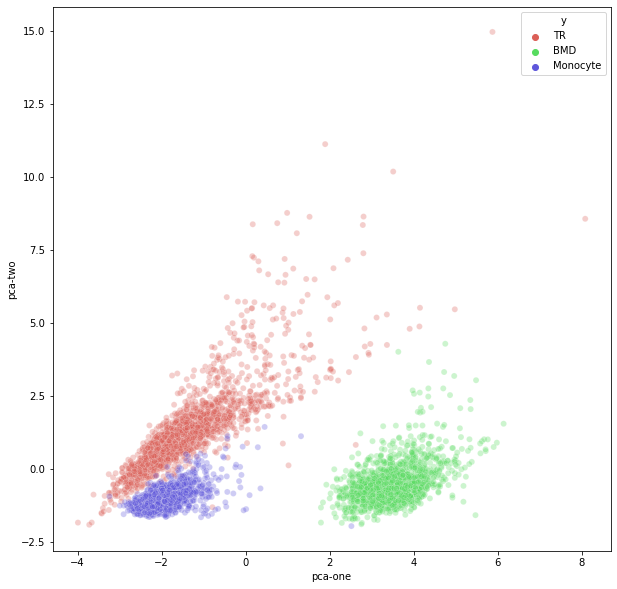

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(train_samples)
std_data = sc.transform(train_samples)
std_test_data = sc.transform(test_samples)

num_comp = 2

pca = PCA(n_components=num_comp)
pca.fit(std_data)
pca_result = pca.transform(std_data)

graph_data = pd.DataFrame()
graph_data['pca-one'] = pca_result[:,0]
graph_data['pca-two'] = pca_result[:,1] 
#graph_data['pca-three'] = pca_result[:,2]  

reverse_pheno = {v: k for k, v in phenotype.items()}

graph_data['y'] = [reverse_pheno[label] for label in train_labels]


print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 3),
    data=graph_data,
    legend="full",
    alpha=0.3
)
plt.show()


In [4]:
def confusion_matrix(out, test_labels):
    num_classes = max(out) + 1

    confusion_matrix = np.zeros((num_classes, num_classes))

    for t, p in zip(out, test_labels):
        confusion_matrix[int(t), int(p)] += 1

    matrix = np.array(confusion_matrix)
    matrix = np.array([i/sum(i) for i in matrix])

    test_accuracy = 0
    for i in range(num_classes):
        test_accuracy += confusion_matrix[i,i]
    test_accuracy = test_accuracy / sum(confusion_matrix.flatten())
    return matrix, test_accuracy

def show_matrix(matrix, labels, title):

    matrix_df = pd.DataFrame(matrix, index=labels, columns=labels)
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(matrix_df, annot=True, fmt='.2%') # font size
    plt.title(title)
    plt.show()

accuracy of decision tree: 98.89%


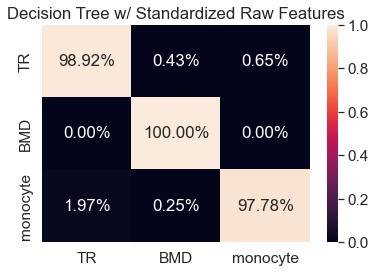

In [5]:
from sklearn.tree import DecisionTreeClassifier
import seaborn as sn
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(std_data, train_labels)
out = list(decision_tree.predict(std_test_data))
matrix, accuracy = confusion_matrix(out, test_labels)
axis_labels = ["TR", "BMD", "monocyte"]
print(f"accuracy of decision tree: {accuracy:>0.2%}")
show_matrix(matrix, axis_labels, 'Decision Tree w/ Standardized Raw Features')

In [6]:
f_1 = np.argmax(decision_tree.feature_importances_)
feature_importances = decision_tree.feature_importances_
importances_ranked = feature_importances.argsort()[::-1]
feature_names = list(data_orig.keys())

important_features = []
print("Most Important Features from Decision Tree")
for i, feature in enumerate(importances_ranked[:10]):
    important_features.append(feature_names[feature])
    print(i+1, important_features[i], f"{feature_importances[importances_ranked[i]]:.2%}")



Most Important Features from Decision Tree
1 Intensity_MinIntensity_macrophage 50.00%
2 Intensity_LowerQuartileIntensity_macrophage 46.99%
3 Intensity_StdIntensity_macrophage 1.85%
4 Intensity_MedianIntensity_macrophage 0.59%
5 Intensity_UpperQuartileIntensity_macrophage 0.20%
6 Intensity_TotalIntensity_macrophage 0.10%
7 Intensity_PercentMaximal_macrophage 0.10%
8 Intensity_MaxIntensity_macrophage 0.09%
9 Intensity_MeanIntensity_macrophage 0.08%
10 Intensity_MADIntensity_macrophage 0.00%


## Plotting Correlation of Features to Mac Clases

https://stackoverflow.com/questions/56153726/plot-k-nearest-neighbor-graph-with-8-features

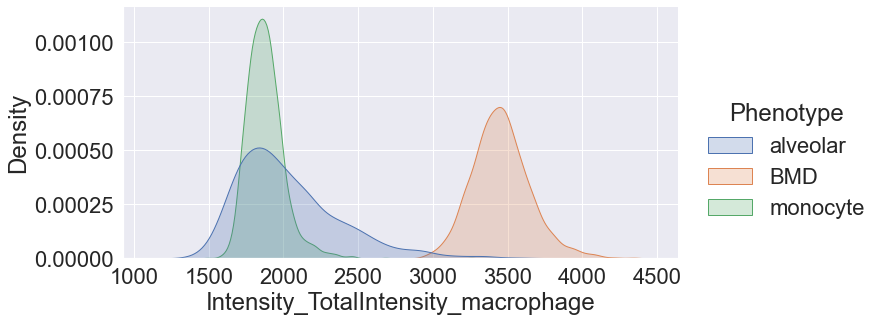

In [9]:
from pylab import rcParams
import re

first_n = 10

corr_features = list(important_features)
corr_features = corr_features[:first_n]
corr_features.append("Phenotype")
corr_data = raw_data[corr_features]


corr_data = corr_data.rename(columns=lambda x: re.sub('Image_','',x))
corr_data = corr_data.rename(columns=lambda x: re.sub('RescaleIntensity_','',x))
corr_data = corr_data.replace("marrow", "BMD")
corr_data = corr_data.replace("alveolar", "TR")
feature_names = corr_features
feature_names.remove("Phenotype")
feature_names = [feat.replace("Image_","") for feat in feature_names]
feature_names = [feat.replace("RescaleIntensity_","") for feat in feature_names]

for i in range(1):
    sns.set(font_scale=2)
    sns.displot(corr_data, x="Intensity_TotalIntensity_macrophage", hue="Phenotype", 
                kind="kde", fill=True, aspect=2)
    
